# Workshop on CIFAR10

Today you will be working on CIFAR10 on your own.

Good luck!

In [1]:
#load everything
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:0


## 1. ETL

In [3]:
#use datasets.CIFAR to get train and test
#then split train to train and val in the percentage of 80:20
transform = transforms.ToTensor()

In [4]:
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

train_data = datasets.CIFAR10(root="../data", train=True, 
                              download=True, transform=transform)
test_set   = datasets.CIFAR10(root="../data", train=False, 
                              download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data), len(test_set)

(50000, 10000)

In [6]:
train_set, val_set = torch.utils.data.random_split(train_data, [40000, 10000])

## 2. EDA

In [7]:
#task1:  please print one sample image of the training set
train_set[0][0].shape 
#shape:  C, W, H

torch.Size([3, 32, 32])

In [8]:
train_set[0][1]
#2 is bird!!!

2

In [9]:
# train_set[0]   #basically image, label

In [10]:
# permute from C, W, H  ===>  W, H, C because imshow wants this shape
image = torch.permute(train_set[0][0], (1, 2, 0))
image.shape

#you can use .view or .reshape

torch.Size([32, 32, 3])

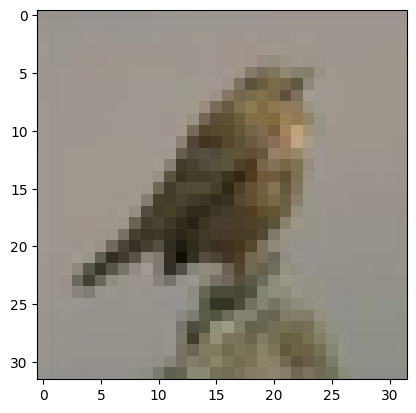

In [11]:
#showtime
plt.imshow(image)

In [12]:
#task2:  check how many labels we have
set(train_data.targets)  #is provided by torch dataset

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [13]:
#task3: for each label, print one sample image
indices = []
labels  = []
for index, label in enumerate(train_data.targets):
    if len(indices) < 10:   #O(1)
        if label not in labels:
            labels.append(label)
            indices.append(index)

In [14]:
labels, indices

([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], [0, 1, 3, 4, 6, 7, 8, 9, 27, 29])

In [15]:
sorted_indices = [label for _, label in sorted(zip(labels, indices))]

Labels:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


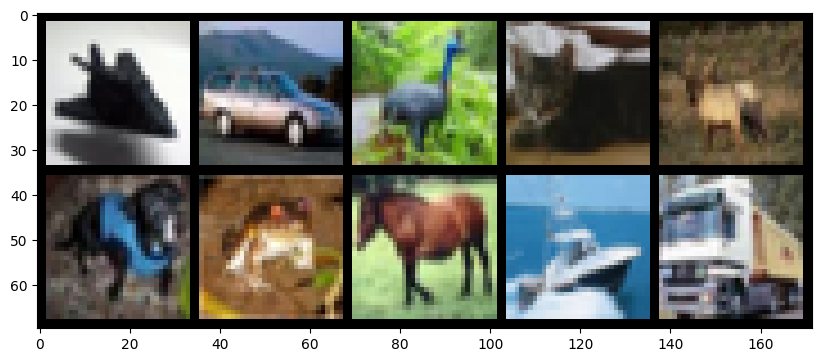

In [16]:
images = []
for i, image_index in enumerate(sorted_indices):  #O(1)
    image = train_data[image_index][0]
    images.append(image)

image_tensor = torch.stack(images, 0)
image_tensor.shape #tensor shape:  B, C, W, H  #(10, 3, 32, 32)

print("Labels: ", torch.arange(10))

grid_image = make_grid(image_tensor, nrow=5)
grid_image = torch.permute(grid_image, (1, 2, 0))
plt.figure(figsize=(10, 8))
plt.imshow(grid_image)

## 3. Create dataloaders for train, val, test

In [17]:
batch_size = 100
train_loader = DataLoader(train_set,batch_size=batch_size,   shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,  batch_size=batch_size,   shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size,   shuffle=False,num_workers=2, pin_memory=True)

In [18]:
### 3.1 Test the dataloader

#shape of image
#shape of label

# for image, label in train_loader:
#     print(image.shape)
#     print(label.shape)
#     break

image = torch.randn((100, 3, 32, 32))

## 4. Test your knowledge on conv2d

In [19]:
image.shape

torch.Size([100, 3, 32, 32])

In [20]:
#create two layers of conv2d
#from 3 -> 256 -> 128
#image shape:  (B, 3, 32, 32)
#nn.Conv2d(in_c, out_c, k, s, p)
#out_size = image_size - k + 2p/s +1
layer1 = nn.Conv2d(3, 256, 3, 1, 0)
out    = layer1(image)
print(out.shape)
#out_size = 32 - 3 / 1 + 1
#after layer1 shape:  (B, 256, 30, 30)
layer2 = nn.Conv2d(256, 128, 3, 1, 0)
out    = layer2(out)
print(out.shape)
#out_size = 30 - 3 / 1 + 1
#after layer2 shape: (B, 128, 28, 28)

#don't forget to reshape (B, 128, 28, 28) ==> (B, 128 * 28 * 28)
out = out.reshape(-1, 128*28*28)

#follow by two linear layers of 128 -> 20 -> 10
layer3 = nn.Linear(128*28*28, 20)
out = layer3(out)
print(out.shape)
#after layer3 shape: (B, 20)
layer4 = nn.Linear(20, 10)
out = layer4(out)
print(out.shape)
#after layer4 shape: (B, 10)

torch.Size([100, 256, 30, 30])
torch.Size([100, 128, 28, 28])
torch.Size([100, 20])
torch.Size([100, 10])


## 5. Design the neural network

In [23]:
class CifarCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        #conv2d (3, 256) -> relu -> batchnorm
        self.conv1 = nn.Conv2d(3, 256, 3, 1, 0)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        
        #conv2d (256, 128) -> relu -> batchnorm
        self.conv2 = nn.Conv2d(256, 128, 3, 1, 0)
        #out_size = 15 - 3 /1 + 1 = 13
        
        #linear (128, 64) -> relu -> linear (64, 20) -> relu -> linear (20, 10)
        self.linear1 = nn.Linear(128*6*6, 64)
        self.linear2 = nn.Linear(64, 20)
        self.linear3 = nn.Linear(20, 10)
        
    def forward(self, image):
        out = self.maxpool(self.relu(self.conv1(image)))
        #out_size = 15
        out = self.maxpool(self.relu(self.conv2(out)))
        out = out.reshape(-1, 128*6*6)
        out = self.relu(self.linear1(out))
        out = self.relu(self.linear2(out))
        
        return self.linear3(out)

## 6. Test the model

In [24]:
#create the model, put them into the device
model = CifarCNN().to(device)

#let's use image (B, C, W, H)
image = image.to(device)

#try input this image to the model
out = model(image)

#check the output size
out.shape #what is 100?  what is 10?

torch.Size([100, 10])

In [25]:
device

device(type='cuda', index=0)

## 7. Count the parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(model)
#conv2d weight = 3 * 256 * 3 * 3 = 6912
#conv2d bias = 256
#256 = gamma of batchnorm
#256 = beta of batchnorm

  6912
   256
294912
   128
294912
    64
  1280
    20
   200
    10
______
598694


## 8. Training!!!

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#how do we know 0.001 is good?

num_epoch = 5
val_old_loss = float("Inf")
filepath = "../models/cifarcnn.pt"
for e in range(num_epoch):
    total_train_corr = 0
    for batch, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        
        yhat  = model(image)           #1. predict  yhat shape(100, 10)
        loss  = criterion(yhat, label) #2. loss
        
        #add accuracy
        predicted  = torch.max(yhat, 1)[1]
        batch_train_corr = (predicted == label).sum()
        total_train_corr += batch_train_corr
        acc = (total_train_corr * 100) / ((batch_size) * (batch + 1))
        
        optimizer.zero_grad()#3. clear gradients
        loss.backward() #4. backpropagate
        optimizer.step() #5. update
        
        if (batch + 1) % 100 == 0:
            # sys.stdout.write(f"\rBatch: {batch+1} - Loss: {loss}")
            print(f"Epoch: {e} - Batch: {batch+1:3.0f} - Loss: {loss:.2f} - Acc: {acc:.2f}")
    
    #after each epoch, calculate the validation acc and loss
    with torch.no_grad():
        total_val_corr = 0
        for (val_image, val_label) in val_loader:
            val_image = val_image.to(device)
            val_label = val_label.to(device)
            val_yhat = model(val_image)
            val_loss = criterion(val_yhat, val_label)
            #save the model with the lowest loss
            if val_loss < val_old_loss:
                torch.save(model.state_dict(), filepath) #state_dict is simply the weights
                val_old_loss = val_loss
            val_predicted = torch.max(val_yhat, 1)[1]
            total_val_corr += (val_predicted == val_label).sum()
        val_acc = (total_val_corr * 100) / len(val_set)
        print(f"++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}")

Epoch: 0 - Batch: 100 - Loss: 1.81 - Acc: 20.49
Epoch: 0 - Batch: 200 - Loss: 1.69 - Acc: 27.67
Epoch: 0 - Batch: 300 - Loss: 1.56 - Acc: 32.12
Epoch: 0 - Batch: 400 - Loss: 1.33 - Acc: 35.22
++++++Validation++++++  Loss: 1.37 - Acc: 46.24
Epoch: 1 - Batch: 100 - Loss: 1.31 - Acc: 47.71
Epoch: 1 - Batch: 200 - Loss: 1.28 - Acc: 48.45
Epoch: 1 - Batch: 300 - Loss: 1.49 - Acc: 48.85
Epoch: 1 - Batch: 400 - Loss: 1.37 - Acc: 49.53
++++++Validation++++++  Loss: 1.28 - Acc: 52.33
Epoch: 2 - Batch: 100 - Loss: 1.28 - Acc: 54.06
Epoch: 2 - Batch: 200 - Loss: 1.38 - Acc: 55.29
Epoch: 2 - Batch: 300 - Loss: 1.26 - Acc: 55.37
Epoch: 2 - Batch: 400 - Loss: 1.25 - Acc: 55.43
++++++Validation++++++  Loss: 1.26 - Acc: 56.42
Epoch: 3 - Batch: 100 - Loss: 1.10 - Acc: 59.20
Epoch: 3 - Batch: 200 - Loss: 1.11 - Acc: 58.77
Epoch: 3 - Batch: 300 - Loss: 1.00 - Acc: 59.00
Epoch: 3 - Batch: 400 - Loss: 1.07 - Acc: 59.15
++++++Validation++++++  Loss: 1.18 - Acc: 58.49
Epoch: 4 - Batch: 100 - Loss: 1.03 - Acc

## 9. Plot the loss and acc

## 10. Check which image we got wrong.....with confusion matrix

- even print out the image we predict wrong...so we can understand how to make better models

## 11. Testing / Inference

In [29]:
#do by yourself
#load the best model based on val loss
model = CifarCNN().to(device)
model.load_state_dict(torch.load(filepath))

#do the testing phase! :-)
with torch.no_grad():
    test_corr = 0 
    for test_image, test_label in test_loader:
        test_image = test_image.to(device)
        test_label = test_label.to(device)
        test_yhat = model(test_image)
        test_loss = criterion(test_yhat, test_label)
        test_predicted = torch.max(test_yhat, 1)[1]
        test_corr += (test_predicted == test_label).sum()
    test_acc = (test_corr * 100) / len(test_set)
    
print(test_acc)

tensor(62.4800, device='cuda:0')
